##Problem statement
The main goal of this project is to  build ML models to predict churn.

1.   predict whether a high-value customer will churn or not
2.   which variable indicates why customers choose to switch to other networks
3. overall accuracy will be the primary evaluation

# 1. Loading dependencies & datasets

In [4]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [7]:
df=pd.read_csv('train.csv')

In [ ]:
df.head(2)

##2.visual the data structure

In [ ]:
#display info with count and no  nulls
df.info(verbose=True, show_counts=True)


In [ ]:
#find all empty value in the data set
df.isnull().mean()*100


In [12]:
## dropped columns where data was not available
df2=df.dropna(axis=1)
df2.shape

(69999, 47)

In [ ]:
#display info with count and no  nulls
df2.info(verbose=True, show_counts=True)

In [20]:
df2.head(2)

,id,circle_id,last_date_of_month_6,arpu_6,arpu_7,arpu_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,6/30/2014,31.277,87.009,7.527,81.21,221.68,3.63,11.84,...,0,0,0,0,0,1958,0.0,0.0,0.0,0
1,1,109,6/30/2014,0.000,122.787,42.953,0.00,30.73,31.66,3.44,...,1,0,0,0,0,710,0.0,0.0,0.0,0


### dropping columns like id circle_id, date

In [21]:
df2 = df2.drop(['id','circle_id','last_date_of_month_6'], axis=1)

In [22]:
y = df2['churn_probability']
data = df2.drop(['churn_probability'], axis=1)

#3. Exploratory Data Analysis & Preprocessing

<Axes: >

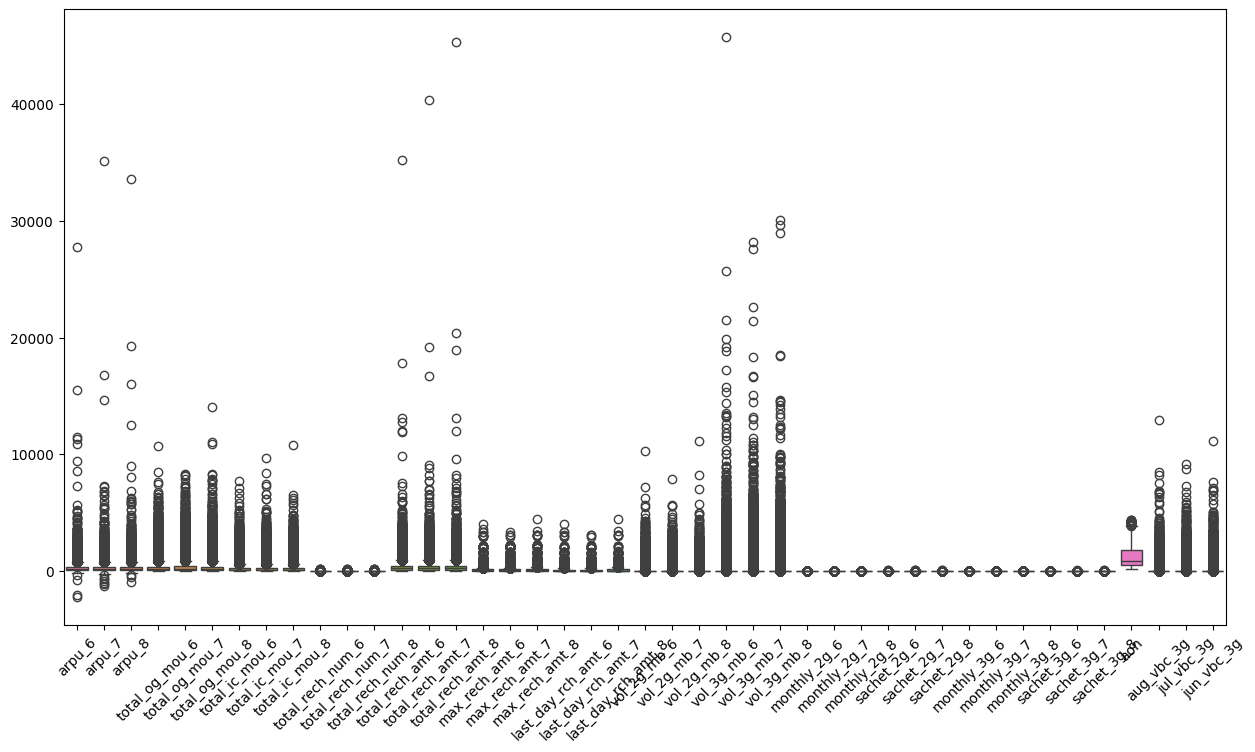

In [23]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = data)

#4. Create X, y and then Train test split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 43), (14000, 43), (55999,), (14000,))

##4.1 handling outlier

<Axes: >

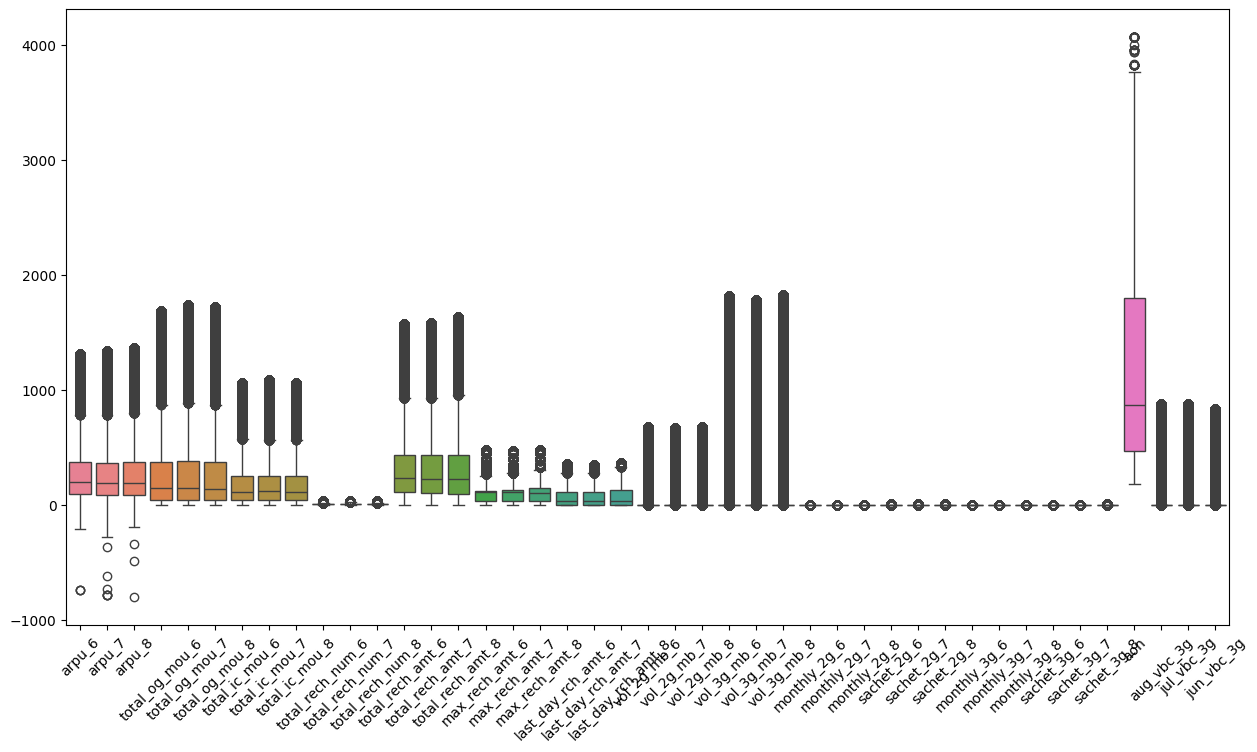

In [25]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array # The return statement is now indented to match the other statements.

X_train = X_train.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train)

#4.2  Feature scaling

In [26]:
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)

In [ ]:
new_vars =  X_train.columns
new_vars

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_scaled, columns=new_vars))

###plot the correlations for each feature for bivariate analysis.

<Axes: >

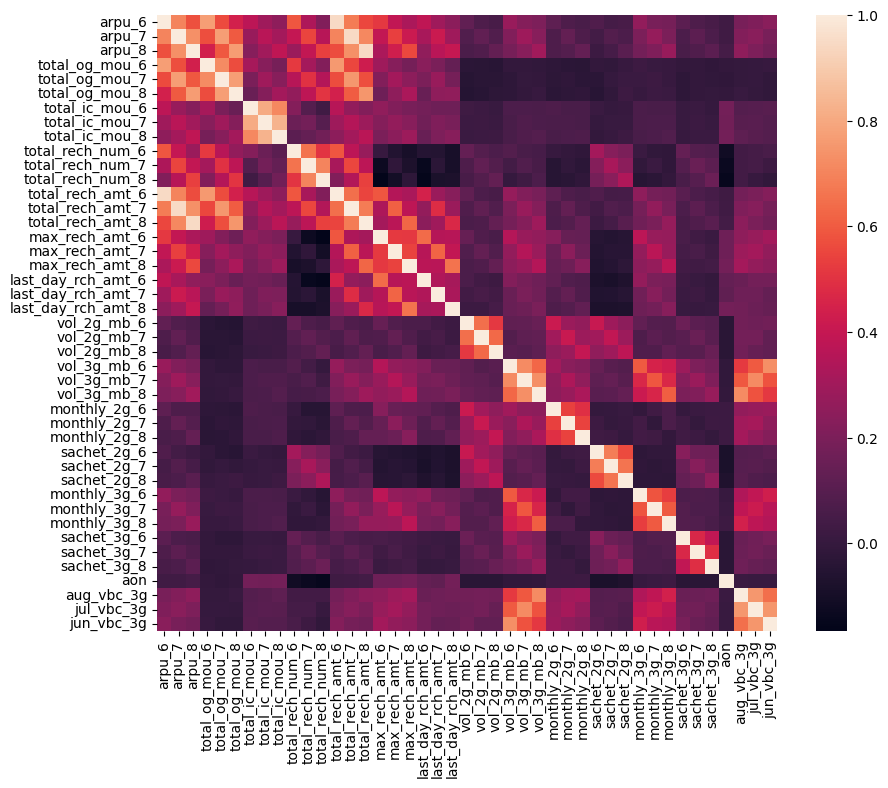

In [29]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_scaled, columns=new_vars).corr())

<Axes: xlabel='churn_probability', ylabel='Count'>

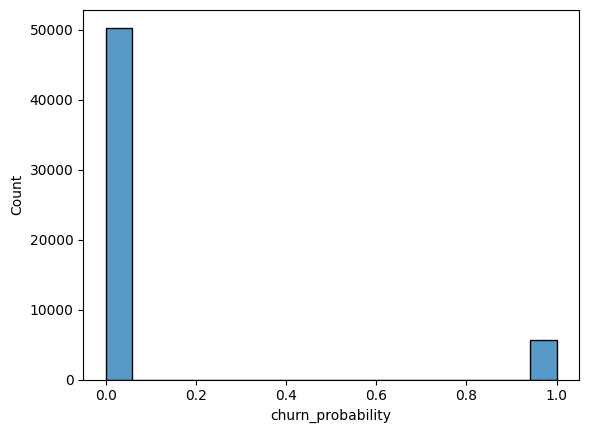

In [30]:
#Distribution for the churn probability
sns.histplot(y_train)

#5. Feature engineering and selection

In [31]:
# feature importances for raw features as well as components to decide top features for modelling.
# decide top features for modelling.
# Change to RandomForestRegressor for continuous target variables
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(n_jobs=-1)

In [32]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})

<BarContainer object of 43 artists>

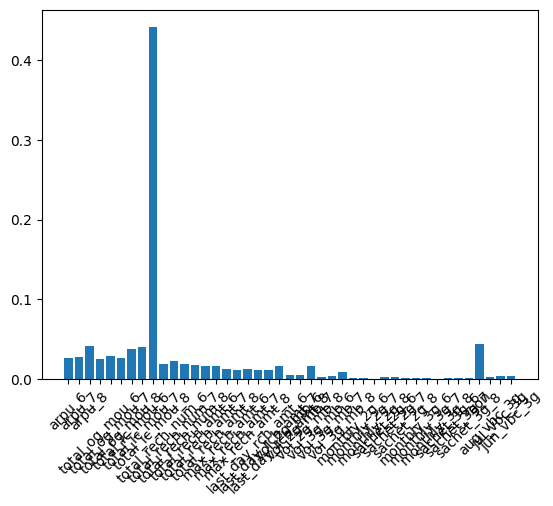

In [33]:
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

<Axes: >

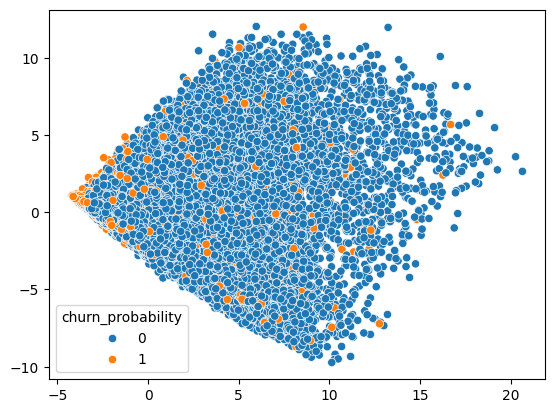

In [34]:
pca = PCA()
pca_components = pca.fit_transform(X_train_scaled)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<Axes: >

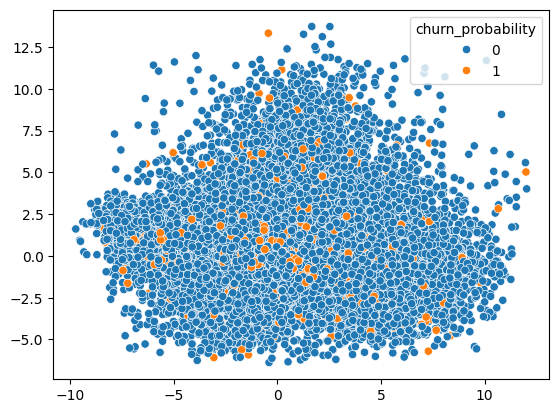

In [35]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

<BarContainer object of 43 artists>

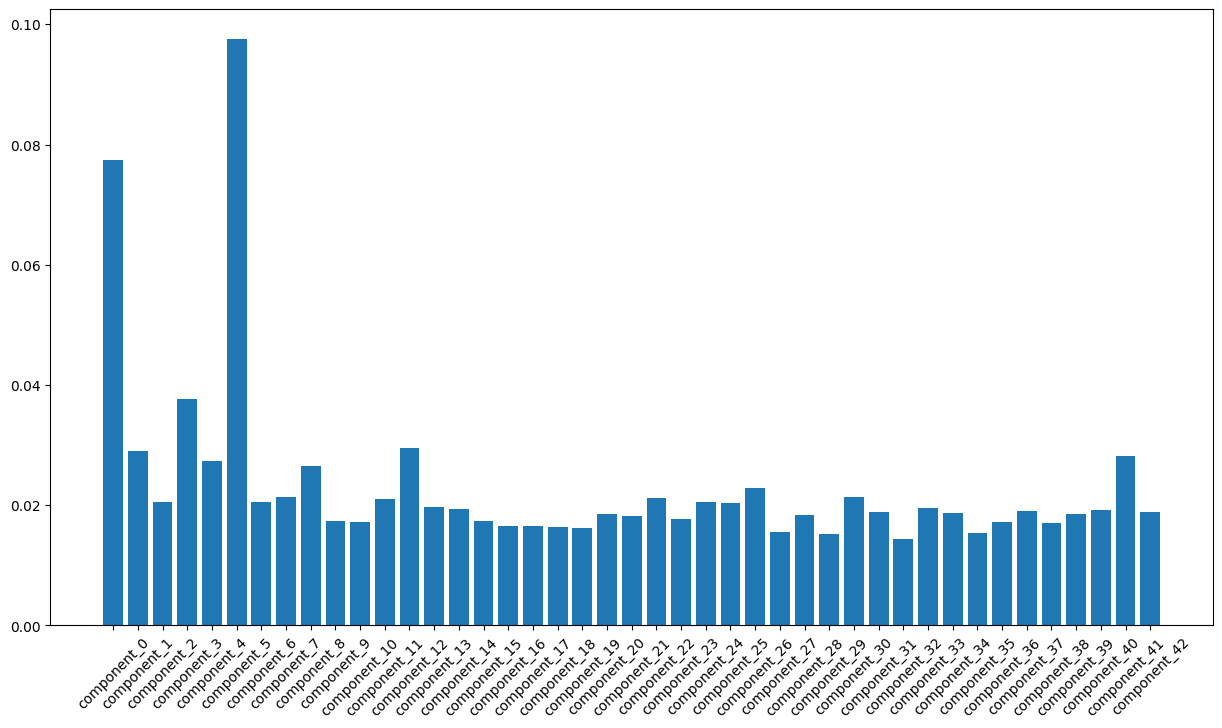

In [36]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
# Check if y_train has continuous values. If so, convert them to discrete values
# using a suitable method like binning or clustering.
# For instance, if y_train represents income, you could bin it into income groups.

# Example of binning using pandas.cut
y_train_binned = pd.cut(y_train, bins=5, labels=False)

rf.fit(pca_components, y_train_binned) # Use the binned y_train

# Determine the number of components in pca_components
n_components = pca_components.shape[1]

feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(n_components)],  # Use n_components
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

## Logistic regression

In [37]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')

# Bin y_train into 5 bins and assign labels 0 to 4
y_train_binned = pd.cut(y_train, bins=5, labels=False)

lr.fit(pca_components[:,:2], y_train_binned) # Fit the model using the binned target variable

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [38]:
lr.score(pca_components[:,:2], y_train_binned) # Evaluate the score using the same binned target variable used for training

0.8988731941641815

In [39]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [40]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [41]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [42]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9048733013089519


In [43]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.8983571428571429


In [44]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[49882,   454],
       [ 4873,   790]])

In [45]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[12393,   138],
       [ 1285,   184]])

In [46]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.5714285714285714

In [47]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

0.12525527569775358

## Preparing submission file

In [48]:
subdf = pd.read_csv('test.csv')

In [50]:
subdf.head(2)

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.0,0.0,0.0
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.0,0.0,0.0


In [51]:
submission_data = subdf.set_index('id')[new_vars]
submission_data.shape

(30000, 43)

In [ ]:
subdf['churn_probability'] = pipe.predict(submission_data)
output = subdf[['id','churn_probability']]
output.head()

In [54]:
output.to_csv('submission_Dinakar_kumar.csv',index=False)